# Face Mask Detection - Haar Cascades and NN

Similar to the previous Drowsiness Detector, this project will predict the contents of a real-time camera feed. The goal is to detect a face, and then predict if the face contains a mask or not.

In [1]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import cv2

from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import imutils
import numpy as np

Using TensorFlow backend.


## Step 1: Download Data
### Training Data
The zip contains folders for train and validation set, each with mask and without mask.

In [2]:
import os
import wget

url = 'https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip'
out_dir = f'{os.getcwd()}\\Data\\facemask_data'
localdataset_zip = out_dir + '\\face-mask-dataset.zip'

if os.path.exists(localdataset_zip):
    print("File exists")
else:
    wget.download(url, out=out_dir)
    print("Download Finished")

File exists


### Haar Cascades kernel
The kernel detects frontal faces.

In [3]:
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml'
localhaar = out_dir + '\\haarcascade_frontalface_alt.xml'

if os.path.exists(localhaar):
    print("File exists")
else:
    wget.download(url, out=out_dir)
    print("Download Finished")

File exists


## Step 2: Unzipping

In [4]:
import zipfile

# unzip the dataset file
zip_ref1 = zipfile.ZipFile(localdataset_zip, 'r')
zip_ref1.extractall(out_dir)
zip_ref1.close()

dataset_dir = out_dir + '\\Dataset'

# unzip the test file
localtest_zip = dataset_dir + '\\test.zip'
zipref2 = zipfile.ZipFile(localtest_zip, 'r')
zipref2.extractall(dataset_dir)
zipref2.close()

# unzip the train file
localtrain_zip = dataset_dir + '\\train.zip'
zipref3 = zipfile.ZipFile(localtrain_zip, 'r')
zipref3.extractall(dataset_dir)
zipref3.close()

In [5]:
train_with_mask_dir = dataset_dir + '\\train\\with_mask'
print('total train with mask images :', len(os.listdir(train_with_mask_dir) ))
train_without_mask_dir = dataset_dir + '\\train\\without_mask'
print('total train witout mask images :', len(os.listdir(train_without_mask_dir) ))

test_with_mask_dir = dataset_dir + '\\test\\with_mask'
print('total test with maks images :', len(os.listdir(test_with_mask_dir) ))
test_without_mask_dir = dataset_dir + '\\test\\without_mask'
print('total test without images :', len(os.listdir(test_without_mask_dir) ))

total train with mask images : 658
total train witout mask images : 656
total test with maks images : 97
total test without images : 97


## Images with mask:

![with_mask](Data\\facemask_data\\with_mask.png)

## Images without mask:
![without_mask](Data\\facemask_data\\without_mask.png)

## Step 3: Pre-Processing - Image Data Generator and Image Augmentation

Labeling in TensorFlow happens via  the folder name. On-the-fly training image augmentation zooms, rotates, mirrors without saving new versions of the images. Rescaling normalizes the pixel values.

In [6]:
training_directory = dataset_dir + "\\train"

train_datagen = ImageDataGenerator(rescale=1./255.,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(training_directory,
                                                    batch_size=10, 
                                                    target_size=(150, 150))



validation_directory = dataset_dir + "\\test"

validation_datagen = ImageDataGenerator(rescale=1./255.)

validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                                batch_size=10,
                                                                target_size=(150, 150))

Found 1314 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


## Step 4: Design Model

In [7]:
model = Sequential([Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPooling2D(2,2),
        
                    Conv2D(100, (3,3), activation='relu'),
                    MaxPooling2D(2,2),
        
                    Flatten(),
                    Dropout(0.5),
                    Dense(50, activation='relu'),
                    Dense(2, activation='softmax')
                    ])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Initialize callback checkpoint to keep saving a model if it improved validation loss after the previous one. The last save should be the best model.

In [8]:
checkpoint = ModelCheckpoint(out_dir+'\\model1-{epoch:03d}.model',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,mode='auto'
                            )

## Step 5: Train Model

In [9]:
history = model.fit_generator(train_generator,
                                epochs=10,
                                validation_data=validation_generator,
                                callbacks=[checkpoint])

Epoch 1/10
132/132 [==============================] - 15s 117ms/step - loss: 0.5455 - accuracy: 0.7344 - val_loss: 0.1351 - val_accuracy: 0.9381

Epoch 00001: val_loss improved from inf to 0.13511, saving model to C:\Users\ChristianV700\Documents\GitHub\DataScienceProjects\Data\facemask_data\model1-001.model
Epoch 2/10
132/132 [==============================] - 11s 81ms/step - loss: 0.3956 - accuracy: 0.8531 - val_loss: 0.0808 - val_accuracy: 0.9330

Epoch 00002: val_loss improved from 0.13511 to 0.08085, saving model to C:\Users\ChristianV700\Documents\GitHub\DataScienceProjects\Data\facemask_data\model1-002.model
Epoch 3/10
132/132 [==============================] - 11s 85ms/step - loss: 0.3893 - accuracy: 0.8615 - val_loss: 0.0912 - val_accuracy: 0.9639

Epoch 00003: val_loss did not improve from 0.08085
Epoch 4/10
132/132 [==============================] - 11s 83ms/step - loss: 0.2748 - accuracy: 0.9018 - val_loss: 0.0364 - val_accuracy: 0.9639

Epoch 00004: val_loss improved from 

Text(0.5, 1.0, 'Loss')

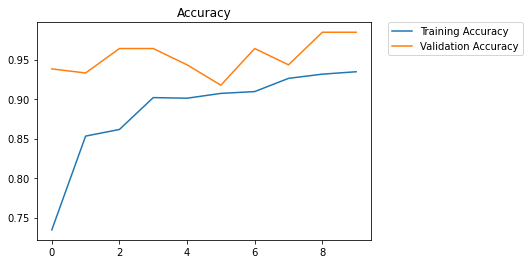

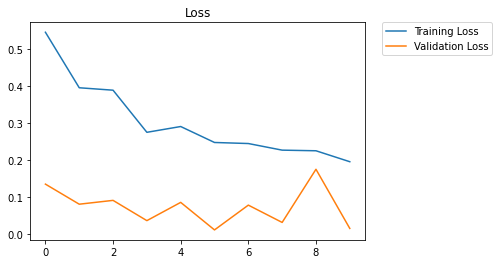

In [10]:
from matplotlib import pyplot as plt

# extract contents from history
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

# Accuracy plot
plt.plot  (epochs,acc,label='Training Accuracy')
plt.plot  (epochs,val_acc,label='Validation Accuracy' )
plt.legend(bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
plt.title ('Accuracy')
plt.figure()

# Loss plot
plt.plot  (epochs,loss,label='Training Loss' )
plt.plot  (epochs,val_loss,label='Validation Loss' )
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)
plt.title ('Loss')

 Accuracy is instantly very high (>90%) with little distance between Training and Validation sets.
 
 ## Step 6: Make Predictions on Camera Feed

In [11]:
import cv2
import numpy as np
from keras.models import load_model

In [13]:
# load the best face mask model
model=load_model(out_dir+"./model1-006.model")

# Capture accesses the video feed. The "0" is the number of your video device, in case you have multiple.
cap = cv2.VideoCapture(0)
if cap.isOpened() == True:
    print("Video stream open.")
else:
    print("Problem opening video stream.")

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}
rect_size = 4

# load haar cascade file
haarcascade = cv2.CascadeClassifier(localhaar)

Video stream open.


In [14]:
while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 
        
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
            
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imshow('LIVE',   im)

    # break the infinite loop when pressing q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## Summary
The haar cacade has its issues with detecting a face when it is wearing a mask. With the eyes only visible, the haar cascade's detection limits are too narrow. Without finding a person, the neural network can't predict if the person is wearing a mask or not.